In [1]:
import pandas as pd

# Cargar el archivo Excel Online Retail
file_path = "Online Retail.xlsx"
df = pd.read_excel(file_path)

# Mostrar las primeras filas para explorar su contenido
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Estadísticas descriptivas generales
print("\nResumen estadístico:")
print(df.describe(include='all'))


Resumen estadístico:
        InvoiceNo StockCode                         Description  \
count    541909.0    541909                              540455   
unique    25900.0      4070                                4223   
top      573585.0    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
freq       1114.0      2313                                2369   
mean          NaN       NaN                                 NaN   
min           NaN       NaN                                 NaN   
25%           NaN       NaN                                 NaN   
50%           NaN       NaN                                 NaN   
75%           NaN       NaN                                 NaN   
max           NaN       NaN                                 NaN   
std           NaN       NaN                                 NaN   

             Quantity                    InvoiceDate      UnitPrice  \
count   541909.000000                         541909  541909.000000   
unique            NaN          

In [7]:
# Convertir InvoiceNo a string para detectar cancelaciones
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

# 1. Eliminar cancelaciones
df = df[~df['InvoiceNo'].str.startswith('C')]

# 2. Eliminar filas con CustomerID nulo
df = df.dropna(subset=['CustomerID'])

# 3. Eliminar precios y cantidades no válidas (<= 0)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Mostrar nuevo tamaño del dataset
print(f"Dataset limpio: {df.shape[0]} filas y {df.shape[1]} columnas.")


Dataset limpio: 397884 filas y 8 columnas.


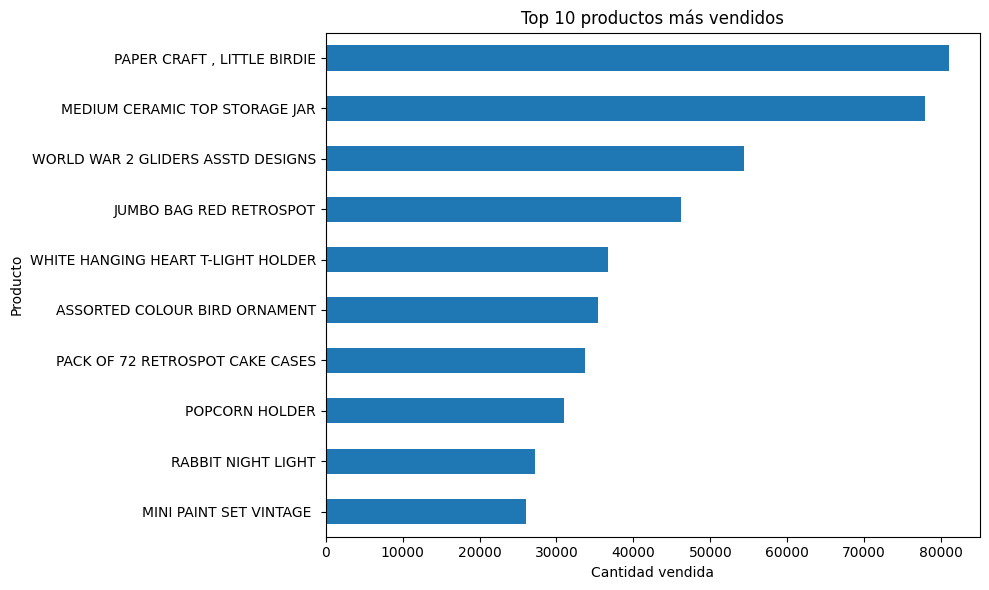

In [8]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

top_products.plot(kind='barh', title='Top 10 productos más vendidos', figsize=(10, 6))
plt.xlabel('Cantidad vendida')
plt.ylabel('Producto')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


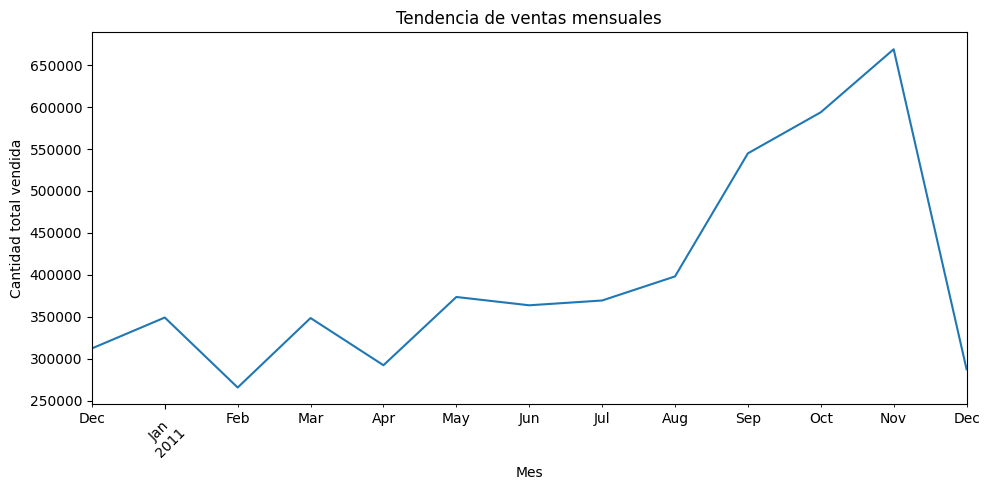

In [9]:
# Asegurarse que la fecha sea datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Crear columna con el mes
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# Agrupar ventas por mes
monthly_sales = df.groupby('Month')['Quantity'].sum()

monthly_sales.plot(title='Tendencia de ventas mensuales', figsize=(10,5))
plt.xlabel('Mes')
plt.ylabel('Cantidad total vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



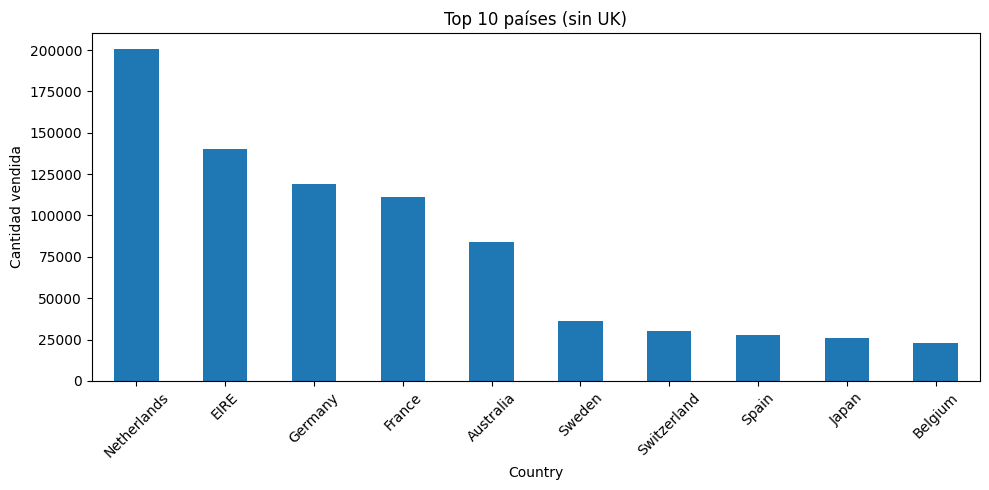

In [10]:
country_sales = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False)

# Excluir United Kingdom si quieres ver solo los países exportadores
country_sales.drop('United Kingdom').head(10).plot(kind='bar', title='Top 10 países (sin UK)', figsize=(10, 5))
plt.ylabel('Cantidad vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Creo variables adicionales para el análisis

# Valor total por línea (ingresos)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Día de la semana
df['Weekday'] = df['InvoiceDate'].dt.day_name()

# Hora del día
df['Hour'] = df['InvoiceDate'].dt.hour

# Nacional vs. Internacional
df['Region'] = df['Country'].apply(lambda x: 'UK' if x == 'United Kingdom' else 'International')

# Estación del año
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['InvoiceDate'].apply(get_season)

# Compras por cliente (cliente recurrente)
customer_freq = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
customer_freq.columns = ['CustomerID', 'NumPurchases']
df = df.merge(customer_freq, on='CustomerID', how='left')

# Verificamos las nuevas columnas
print(df[['TotalPrice', 'Weekday', 'Hour', 'Region', 'Season', 'NumPurchases']].head())


   TotalPrice    Weekday  Hour Region  Season  NumPurchases
0       15.30  Wednesday     8     UK  Winter            34
1       20.34  Wednesday     8     UK  Winter            34
2       22.00  Wednesday     8     UK  Winter            34
3       20.34  Wednesday     8     UK  Winter            34
4       20.34  Wednesday     8     UK  Winter            34


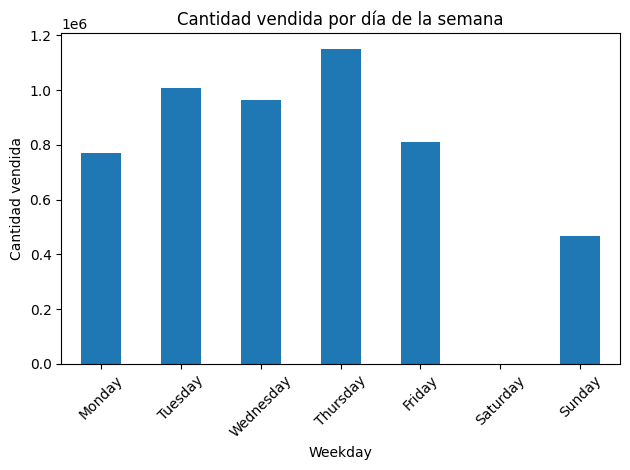

In [12]:
weekday_sales = df.groupby('Weekday')['Quantity'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

weekday_sales.plot(kind='bar', title='Cantidad vendida por día de la semana')
plt.ylabel('Cantidad vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

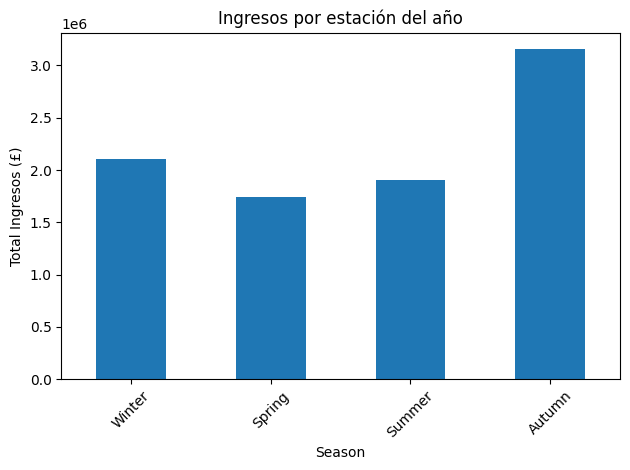

In [13]:
season_revenue = df.groupby('Season')['TotalPrice'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

season_revenue.plot(kind='bar', title='Ingresos por estación del año')
plt.ylabel('Total Ingresos (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


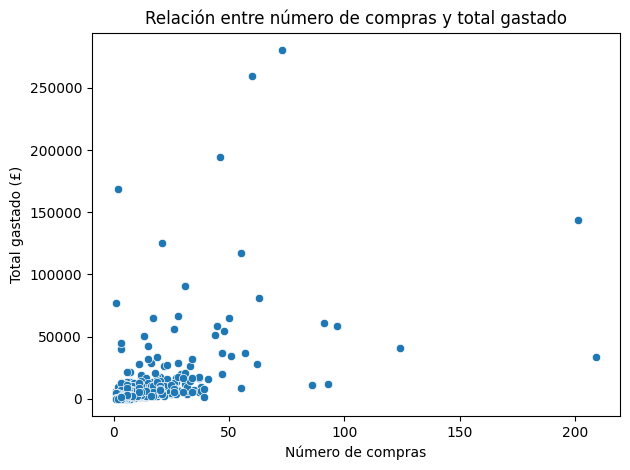

In [14]:
# Agrupar clientes por número de compras y total gastado
client_value = df.groupby('CustomerID').agg({
    'NumPurchases': 'first',
    'TotalPrice': 'sum'
})

sns.scatterplot(data=client_value, x='NumPurchases', y='TotalPrice')
plt.title('Relación entre número de compras y total gastado')
plt.xlabel('Número de compras')
plt.ylabel('Total gastado (£)')
plt.tight_layout()
plt.show()


In [15]:
df.to_csv("online_retail_limpio.csv", index=False)
